In [1]:
import os
import copy
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfea
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
from matplotlib.colors import CSS4_COLORS
from matplotlib.patches import Rectangle

In [2]:
# conversion from l coordinate to lonlat coordinate
def l_coordinate_to_tuple(lcoordinate, a=2160, b=4320):
    lat_l = a - ((lcoordinate - 1) // b)
    lon_l = (lcoordinate) % b - 1
    return (lat_l, lon_l)

#---------------------------------------------------------------------------------------------------------------
# 流域IDと色の紐付け
#---------------------------------------------------------------------------------------------------------------

def get_unique_non_masked_values(values):
    result = []
    for value in np.unique(values):
        if value is not np.ma.masked and not np.isnan(value):
            result.append(value)
    return result

def is_whiteish(color):
    r, g, b = [int(color[i:i+2], 16) for i in (1, 3, 5)]  # Convert hex to RGB
    return (r + g + b) / 3 > 230  # Check if the average is above the threshold

def is_grayish(color):
    r, g, b = [int(color[i:i+2], 16) for i in (1, 3, 5)]  # Convert hex to RGB
    deviation = max(r, g, b) - min(r, g, b)
    return deviation <= 20

def is_blueish(color):
    r, g, b = [int(color[i:i+2], 16) for i in (1, 3, 5)]  # Convert hex to RGB
    return  b - r > 120 and b - g > 120  # If blue is dominant and significantly larger

def get_filtered_colors(all_colors):
    result = []
    for color in all_colors:
        if color != '#00FFFF' and not is_whiteish(color) and not is_grayish(color) and not is_blueish(color):
            result.append(color)
    return result

def make_cmap(Rivnum_masked_array):
    # ユニークな流域の数をカウント
    unique_values = get_unique_non_masked_values(Rivnum_masked_array)
    num_colors = len(unique_values)

    # 流域に固有の色を割り振る
    all_colors = list(CSS4_COLORS.values())
    filtered_colors = get_filtered_colors(all_colors)
    colors_list = filtered_colors[:num_colors]

    # -1<=x<0に透明色を追加
    colors_list.insert(0, '#00000000')

    # HTMLカラーコードに変化してlisted colormap を作成
    cmap = ListedColormap(colors_list)

    # [辞書作る] key=流域ID, value=0から数えたindex　
    index_dict = {}
    for i, value in enumerate(unique_values):
        index_dict[value] = i

    return num_colors, index_dict, cmap

def get_index(val, index_dict):
    return index_dict.get(val, -1)  # nan or unexpected values are mapped to -1

In [51]:
#--------------------------------------------------------------------------------------------------------------
# PATH
#---------------------------------------------------------------------------------------------------------------
POP='gpw4'
SUF='.gl5'
#
glbdir = "/mnt/c/Users/tsimk/Downloads/dotfiles/h08/global_city"
# lonlat data
file_path = f"{glbdir}/dat/cty_lst_/{POP}/WUP2018_300k_2010.txt"

#---------------------------------------------------------------------------------------------------------------
# Initialization
#---------------------------------------------------------------------------------------------------------------
loop_start = 0
city_index = 1 # number of the city

# remove small river criteria
remove_grid = 5
innermask_grid = 3

# population range
pop_vmin = 1e4
pop_vmax = 1e6
width = 1
resolution = 12
a = 2160
b = 4320

#---------------------------------------------------------------------------------------------------------------
# Input Data
#---------------------------------------------------------------------------------------------------------------
# load takahashi data
josui = pd.read_csv(josui_path)
gesui = pd.read_csv(gesui_path)
seki = pd.read_csv(seki_path)

# city_list.txtを開いてデータを読み取る
with open(file_path, "r") as input_file:
    lines = input_file.readlines() 
    
line=lines[city_index - 1]
parts = line.split('\t')
parts = [item.strip() for item in parts]
latcnt = float(parts[1])
loncnt = float(parts[2])
city_name = parts[4]

# widthを使用して新しいデータを計算
latmin = float(latcnt - width)
latmax = float(latcnt + width)
lonmin = float(loncnt - width)
lonmax = float(loncnt + width)
sotowaku_latmin = float(latcnt - width*resolution)
sotowaku_latmax = float(latcnt + width*resolution)
sotowaku_lonmin = float(loncnt - width*resolution)
sotowaku_lonmax = float(loncnt + width*resolution)

#---------------------------------------------------------------------------------------------------------------
# Get Lon Lat 
#---------------------------------------------------------------------------------------------------------------

# この部分怪しいかもしれない
lat = np.linspace(-90, 90, a+1)
lon = np.linspace(-180, 180, b+1)
lat_start, lat_end = np.searchsorted(lat, [latmin, latmax])
lon_start, lon_end = np.searchsorted(lon, [lonmin, lonmax])
sotowaku_latstart, sotowaku_latend = np.searchsorted(lat, [sotowaku_latmin, sotowaku_latmax])
sotowaku_lonstart, sotowaku_lonend = np.searchsorted(lon, [sotowaku_lonmin, sotowaku_lonmax])

# adjust to 0.25 grid (lonlat)
if lat_start%3 == 0:
    lat_start = lat_start
elif lat_start%3 == 1:
    lat_start -= 1
elif lat_start%3 == 2:
    lat_start += 1
# lon
if lon_start%3 == 0:
    lon_start = lon_start
elif lon_start%3 == 1:
    lon_start -= 1
elif lon_start%3 == 2:
    lon_start += 1
    
# adjust to 0.25 grid (lonlat)
if sotowaku_latstart%3 == 0:
    sotowaku_latstart = sotowaku_latstart
elif sotowaku_latstart%3 == 1:
    sotowaku_latstart -= 1
elif sotowaku_latstart%3 == 2:
    sotowaku_latstart += 1
# lon
if sotowaku_lonstart%3 == 0:
    sotowaku_lonstart = sotowaku_lonstart
elif sotowaku_lonstart%3 == 1:
    sotowaku_lonstart -= 1
elif sotowaku_lonstart%3 == 2:
    sotowaku_lonstart += 1
    
# 24 x 24 grid
width_grid = width * resolution * 2
lat_end = lat_start + width_grid
lon_end = lon_start + width_grid

# 288 x 288 grid
sotowaku_widthgrid = width * resolution * resolution * 2
sotowaku_latend = sotowaku_latstart + sotowaku_widthgrid
sotowaku_lonend = sotowaku_lonstart + sotowaku_widthgrid

# convert real lonlat to h08 lonlat
latmin_gl5 = lat[lat_start]
latmax_gl5 = lat[lat_end]
lonmin_gl5 = lon[lon_start]
lonmax_gl5 = lon[lon_end]

sotowaku_latmin_gl5 = lat[sotowaku_latstart]
sotowaku_latmax_gl5 = lat[sotowaku_latend]
sotowaku_lonmin_gl5 = lon[sotowaku_lonstart]
sotowaku_lonmax_gl5 = lon[sotowaku_lonend]

# projection/
projection = ccrs.PlateCarree()
extent = (lonmin_gl5, lonmax_gl5, latmin_gl5, latmax_gl5)
extent2 = (sotowaku_lonmin_gl5, sotowaku_lonmax_gl5, sotowaku_latmin_gl5, sotowaku_latmax_gl5)
print(extent, extent2)

(138.75, 140.75, 34.75, 36.75) (127.75, 151.75, 23.75, 47.75)


In [52]:
#--------------------------------------------------------------------------------------------------------------
# PATH
#---------------------------------------------------------------------------------------------------------------
# city mask data
cmsk_path = f"{glbdir}/dat/cty_msk_/{POP}"
elv_path = f"{glbdir}/dat/elevtn__/elevtn.CAMA{SUF}"
pop_path = f"{glbdir}/dat/pop_tot_/GPW4ag__20100000{SUF}" # @kajiyama
# riv data
rivnum_path = f"{glbdir}/dat/riv_num_/rivnum.CAMA{SUF}"
rivara_path = f"{glbdir}/dat/riv_ara_/rivara.CAMA{SUF}"
rivnxl_path = f"{glbdir}/dat/riv_nxl_/rivnxl.CAMA{SUF}"
# takahashi data
josui_path = f"{glbdir}/dat/fcl_obs_/jyousui_20240109.csv"
gesui_path = f"{glbdir}/dat/fcl_obs_/gesui_20240109.csv"
seki_path = f"{glbdir}/dat/fcl_obs_/suigen_20240109.csv"

#---------------------------------------------------------------------------------------------------------------
#  Load takahashi data
#---------------------------------------------------------------------------------------------------------------
josui = pd.read_csv(josui_path)
gesui = pd.read_csv(gesui_path)
seki = pd.read_csv(seki_path)

#---------------------------------------------------------------------------------------------------------------
#  Load city mask
#---------------------------------------------------------------------------------------------------------------

g_mask = np.fromfile(f'{cmsk_path}/city_{city_index:08}.gl5', 'float32').reshape(a, b)
g_mask = np.flipud(g_mask)
g_mask = np.ma.masked_where(g_mask >= 1e20, g_mask)
g_mask_cropped = g_mask[lat_start:lat_end, lon_start:lon_end]
g_mask_cropped = np.flipud(g_mask_cropped)

#---------------------------------------------------------------------------------------------------------------
#  Load population
#---------------------------------------------------------------------------------------------------------------

g_pop = np.fromfile(pop_path, 'float32').reshape(a, b)
g_pop = np.flipud(g_pop)
g_pop = np.ma.masked_where(g_pop >= 1e20, g_pop)
g_pop_cropped = g_pop[lat_start:lat_end, lon_start:lon_end]
g_pop_cropped = np.flipud(g_pop_cropped)

#---------------------------------------------------------------------------------------------------------------
#  Load basin data
#---------------------------------------------------------------------------------------------------------------

g_rivnum = np.fromfile(rivnum_path, 'float32').reshape(a, b)
g_rivnum = np.flipud(g_rivnum)
g_rivnum = np.ma.masked_where(g_rivnum >= 1e20, g_rivnum)
g_rivnum_cropped = g_rivnum[lat_start:lat_end, lon_start:lon_end]
g_rivnum_cropped = np.flipud(g_rivnum_cropped)
g_rivnum_cropped = np.ma.masked_where(~np.isfinite(g_rivnum_cropped) | (g_rivnum_cropped == 0), g_rivnum_cropped)

#---------------------------------------------------------------------------------------------------------------
#  Load upper river catchment area
#---------------------------------------------------------------------------------------------------------------

g_rivara = np.fromfile(rivara_path, 'float32').reshape(a, b)
g_rivara = np.flipud(g_rivara)
g_rivara = np.ma.masked_where(g_rivara >= 1e20, g_rivara)
g_rivara_cropped = g_rivara[lat_start:lat_end, lon_start:lon_end]
g_rivara_cropped = np.flipud(g_rivara_cropped)
g_rivara_cropped = np.ma.masked_where(~np.isfinite(g_rivara_cropped) | (g_rivara_cropped == 0), g_rivara_cropped)

#---------------------------------------------------------------------------------------------------------------
#  Load river's next l coordinate data
#---------------------------------------------------------------------------------------------------------------

g_rivnxl = np.fromfile(rivnxl_path, 'float32').reshape(a, b)
g_rivnxl = np.flipud(g_rivnxl)
g_rivnxl = np.ma.masked_where(g_rivnxl >= 1e20, g_rivnxl)
g_rivnxl_cropped = g_rivnxl[lat_start:lat_end, lon_start:lon_end]
g_rivnxl_cropped = np.flipud(g_rivnxl_cropped)
g_rivnxl_cropped = np.ma.masked_where(~np.isfinite(g_rivnxl_cropped) | (g_rivnxl_cropped == 0), g_rivnxl_cropped)

In [58]:
#---------------------------------------------------------------------------------------------------------------
#   流域面積と流域番号を持った３次元の配列(g_ara_num_cropped)
#---------------------------------------------------------------------------------------------------------------

# g_ara_num_croppedを構造化配列として作成
dtype = [('rivara', 'float32'), ('rivnum', 'float32')]
g_ara_num_cropped = np.empty(g_rivara_cropped.shape, dtype=dtype)

# rivaraとrivnumのデータをg_ara_num_croppedに追加
g_ara_num_cropped['rivara'] = g_rivara_cropped
g_ara_num_cropped['rivnum'] = g_rivnum_cropped

#---------------------------------------------------------------------------------------------------------------
#   g_rivnum_croppedのnan値をマスクした配列(Rivnum_A_array_masked)
#---------------------------------------------------------------------------------------------------------------

# g_rivnum_croppedのrivnumをマスク付き配列として取得
Rivnum_A_array_masked = np.ma.masked_array(g_ara_num_cropped['rivnum'], np.isnan(g_ara_num_cropped['rivnum']))

#---------------------------------------------------------------------------------------------------------------
#   都市域内のみの流域番号データ(Rivnum_A_array_city)
#---------------------------------------------------------------------------------------------------------------

Rivnum_A_array_city = np.where(g_mask_cropped == 1, g_rivnum_cropped, np.nan)
Rivnum_A_array_city = np.ma.masked_where(~np.isfinite(Rivnum_A_array_city) | (Rivnum_A_array_city == 0), Rivnum_A_array_city)

#---------------------------------------------------------------------------------------------------------------
#   グリッドの少ない流域を省いて主要な流域を選ぶ(Rivnum_B_array)
#---------------------------------------------------------------------------------------------------------------

# マスクされていない要素(Nanじゃない値)のユニークな値とその出現回数を取得
unique_values, counts = np.unique(Rivnum_A_array_masked.compressed(), return_counts=True)
value_counts_dict = dict(zip(unique_values, counts))

# 値（個数）の多い順にソート
# 都市マスク内の流域番号で，出現回数が多い順に並んでいるはず
sorted_dict_by_value_descending = dict(sorted(value_counts_dict.items(), key=lambda item: item[1], reverse=True))

# 値（個数）がremove grid以上の項目のみを持つ新しい辞書を作成
# 流域が小さい物は削除する作業に該当
filtered_dict_g12 = {key: value for key, value in sorted_dict_by_value_descending.items() if value >= remove_grid}

# 空っぽのマスク配列(24x24を作る)
Rivnum_B_array = np.ma.masked_all(Rivnum_A_array_masked.shape, dtype='float32')

# filtered_dict_g12のキー(流域ID)に対して繰り返し処理を行い、
# それぞれのrivnumがRivnum_A_array_maskedに存在する位置を特定します。
for rivnum_id in filtered_dict_g12.keys():
    # 同じrivnumの位置を取得
    matching_positions = np.where(Rivnum_A_array_masked.data == rivnum_id)
    # これらの位置に新しい配列にrivnumを設定
    Rivnum_B_array[matching_positions] = rivnum_id
    
# 0 or 非有限数の要素をマスクする
# Rivnum_B_arrayは都市マスクなしのすべての流域
Rivnum_B_array = np.ma.masked_where(~np.isfinite(Rivnum_B_array) | (Rivnum_B_array == 0), Rivnum_B_array)

#---------------------------------------------------------------------------------------------------------------
#   Rivnum_B_arrayの都市マスク内のみのデータ(cityarea_with_rivnum_b_array)
#---------------------------------------------------------------------------------------------------------------

#cityarea_with_rivnum_b_array   はremove_gridが有効になっている = 都市マスク内 + 全流域が7グリッド以上

# Rivnum_B_arrayの値が存在しないか、値が0の場所をTrueとするマスクを作成
invalid_mask = np.isnan(Rivnum_B_array) | (Rivnum_B_array == 0)
# g_mask_croppedが1でない場所(都市外)、または上記のマスクが真の場所がマスクされたRivnum_B_array
cityarea_with_rivnum_b_array = np.ma.masked_where((g_mask_cropped != 1) | invalid_mask, Rivnum_B_array)

#---------------------------------------------------------------------------------------------------------------
#   rivaraを使って河口グリッドを探索する(rivnum_max_array)
#---------------------------------------------------------------------------------------------------------------

# マスクされていない要素のユニークな値とその出現回数を取得
# 都市マスク内の流域グリッド数で出現回数が多い物を探索している
unique_values, counts = np.unique(cityarea_with_rivnum_b_array.compressed(), return_counts=True)
value_counts_dict = dict(zip(unique_values, counts))

# データ型とサイズに基づいて新しい配列を作成
rivnum_max_array = np.ma.masked_all(g_ara_num_cropped.shape, dtype='float32')

for rivnum_id in value_counts_dict.keys():
    # 同じrivnumの位置を取得
    matching_positions = np.where(cityarea_with_rivnum_b_array == rivnum_id) 
    # これらの位置におけるrivaraの最大値の位置を取得
    max_rivara_position = np.argmax(g_rivara_cropped[matching_positions])       
    # 最大のrivaraの位置に対応するrivnumを新しい配列に保存する
    # 河口グリッドに該当
    rivnum_max_array[matching_positions[0][max_rivara_position], matching_positions[1][max_rivara_position]] = rivnum_id
    
#---------------------------------------------------------------------------------------------------------------
#   make riv nextl lonlat coordinate array 24x24x2(result_2424)
#---------------------------------------------------------------------------------------------------------------

# l coordiate to lonlat coordinate
vfunc = np.vectorize(l_coordinate_to_tuple, otypes=[tuple])
result = np.empty(g_rivnxl_cropped.shape, dtype=tuple)
mask = ~np.isnan(g_rivnxl_cropped)
result[mask] = vfunc(g_rivnxl_cropped[mask])
result_shape = (result.shape[0], result.shape[1], 2)

result_list = []
for row in result:
    for x, y in row:
        # width_grid = cropped scale(24x24)
        modified_x = width_grid - (x - lat_start)
        modified_y = y - lon_start
        result_list.append((modified_x, modified_y))

result_2424 = np.array(result_list).reshape(result_shape)
result_2424 = result_2424.astype(int)
    
#---------------------------------------------------------------------------------------------------------------
#  河口から主河川を探索
#  その中で流域面積が最大になるグリッドを探索(riv_path_array)
#---------------------------------------------------------------------------------------------------------------

results_dict = {}
# マスク内に存在する流域ID
unique_ids = np.unique(rivnum_max_array.compressed())
#riv_path_array = rivnum_max_array.copy()
riv_path_array = np.ma.masked_all(rivnum_max_array.shape, dtype='float32')
visited_coords = set()

for uid in unique_ids:
    # 河口グリッドのインデックス
    coords_a = np.argwhere(rivnum_max_array == uid)
    riv_path_array[coords_a[0][0], coords_a[0][1]] = uid
    if coords_a.size > 0:
        target_coord = tuple(coords_a[0]) 
        path_coords = [target_coord]
        for _ in range(300):
            if target_coord in visited_coords:
                break
            visited_coords.add(target_coord)
            # result_2424はrivnxlのlonlat表示なので，target_coordを次のセルに指し示すrivnxlのインデックスを取得
            matched_coords = np.argwhere(np.all(target_coord == result_2424, axis=2))
            if len(matched_coords) == 0:
                break
            # マッチしたインデックスの中でrivaraが最大のものを選ぶ
            unvisited_matched = [tuple(coord) for coord in matched_coords if tuple(coord) not in visited_coords]
            if not unvisited_matched:
                break
            # g_rivara_croppedに座標をいれて，最大最小を比べている
            rivara_values = [g_rivara_cropped[coord[0], coord[1]] for coord in unvisited_matched]
            max_index = np.argmax(rivara_values)
            best_coord = unvisited_matched[max_index]
            # 河口グリッドのファイルに経路をそれぞれ足していく
            riv_path_array[best_coord[0], best_coord[1]] = uid
            target_coord = best_coord 
            # path_coordに経路を足していく
            path_coords.append(target_coord)

        # 各流域の経路を保存
        results_dict[uid] = path_coords
        
#---------------------------------------------------------------------------------------------------------------
#  　都市マスク内で主河道が3グリッド未満の流域を省く(riv_path_array_revised)
#---------------------------------------------------------------------------------------------------------------

# city mask
fill_value = 1e20
riv_path_array_tmp = riv_path_array.filled(fill_value)
riv_path_city = np.where(g_mask_cropped==1, riv_path_array_tmp, fill_value)
riv_path_array_revised = copy.deepcopy(riv_path_city)

for uid in unique_ids:
    count = 0
    mask = (riv_path_city == uid)
    count = np.sum(mask)
    if count < innermask_grid:
        riv_path_array_revised[riv_path_array_revised == uid] = fill_value
        
riv_path_array_revised = np.ma.masked_where(riv_path_array_revised >= fill_value, riv_path_array_revised)

#---------------------------------------------------------------------------------------------------------------
#  　省かれたユニークな流域番号(unique_ids_new)
#---------------------------------------------------------------------------------------------------------------

unique_ids_new, _ = np.unique(riv_path_array_revised, return_counts=True)

#---------------------------------------------------------------------------------------------------------------
#   都市マスク内に存在する流域(unique_id)を全範囲(Rivnum_B_array)で取得する (Rivnum_masked_array)
#---------------------------------------------------------------------------------------------------------------

Rivnum_masked_array = np.ma.masked_all(Rivnum_A_array_masked.shape, dtype='float32')
for uid in unique_ids_new:
    row_indices, col_indices = np.where(Rivnum_B_array == uid)
    Rivnum_masked_array[row_indices, col_indices] = uid
    
#---------------------------------------------------------------------------------------------------------------
#   新しい河口グリッドを探索する (rivnum_max_array_revised)
#---------------------------------------------------------------------------------------------------------------

# データ型とサイズに基づいて新しい配列を作成
rivnum_max_array_revised = np.ma.masked_all(g_ara_num_cropped.shape, dtype='float32')

for rivnum_id in unique_ids_new:
    # 同じrivnumの位置を取得
    matching_positions = np.where(cityarea_with_rivnum_b_array == rivnum_id) 
    # これらの位置におけるrivaraの最大値の位置を取得
    max_rivara_position = np.argmax(g_rivara_cropped[matching_positions])       
    # 最大のrivaraの位置に対応するrivnumを新しい配列に保存する
    # 河口グリッドに該当
    rivnum_max_array_revised[matching_positions[0][max_rivara_position], matching_positions[1][max_rivara_position]] = rivnum_id

#---------------------------------------------------------------------------------------------------------------
#   新しいriv path探索する (riv_path_array_revised_whole)
#---------------------------------------------------------------------------------------------------------------

results_dict = {}
# マスク内に存在する流域ID
unique_ids = np.unique(rivnum_max_array_revised.compressed())
riv_path_array = np.ma.masked_all(rivnum_max_array.shape, dtype='float32')
visited_coords = set()

for uid in unique_ids:
    # 河口グリッドのインデックス
    coords_a = np.argwhere(rivnum_max_array == uid)
    riv_path_array[coords_a[0][0], coords_a[0][1]] = uid
    if coords_a.size > 0:
        target_coord = tuple(coords_a[0]) 
        path_coords = [target_coord]
        for _ in range(300):
            if target_coord in visited_coords:
                break
            visited_coords.add(target_coord)
            # result_2424はrivnxlのlonlat表示なので，target_coordを次のセルに指し示すrivnxlのインデックスを取得
            matched_coords = np.argwhere(np.all(target_coord == result_2424, axis=2))
            if len(matched_coords) == 0:
                break
            # マッチしたインデックスの中でrivaraが最大のものを選ぶ
            unvisited_matched = [tuple(coord) for coord in matched_coords if tuple(coord) not in visited_coords]
            if not unvisited_matched:
                break
            # g_rivara_croppedに座標をいれて，最大最小を比べている
            rivara_values = [g_rivara_cropped[coord[0], coord[1]] for coord in unvisited_matched]
            max_index = np.argmax(rivara_values)
            best_coord = unvisited_matched[max_index]
            # 河口グリッドのファイルに経路をそれぞれ足していく
            riv_path_array[best_coord[0], best_coord[1]] = uid
            target_coord = best_coord 
            # path_coordに経路を足していく
            path_coords.append(target_coord)

        # 各流域の経路を保存
        results_dict[uid] = path_coords

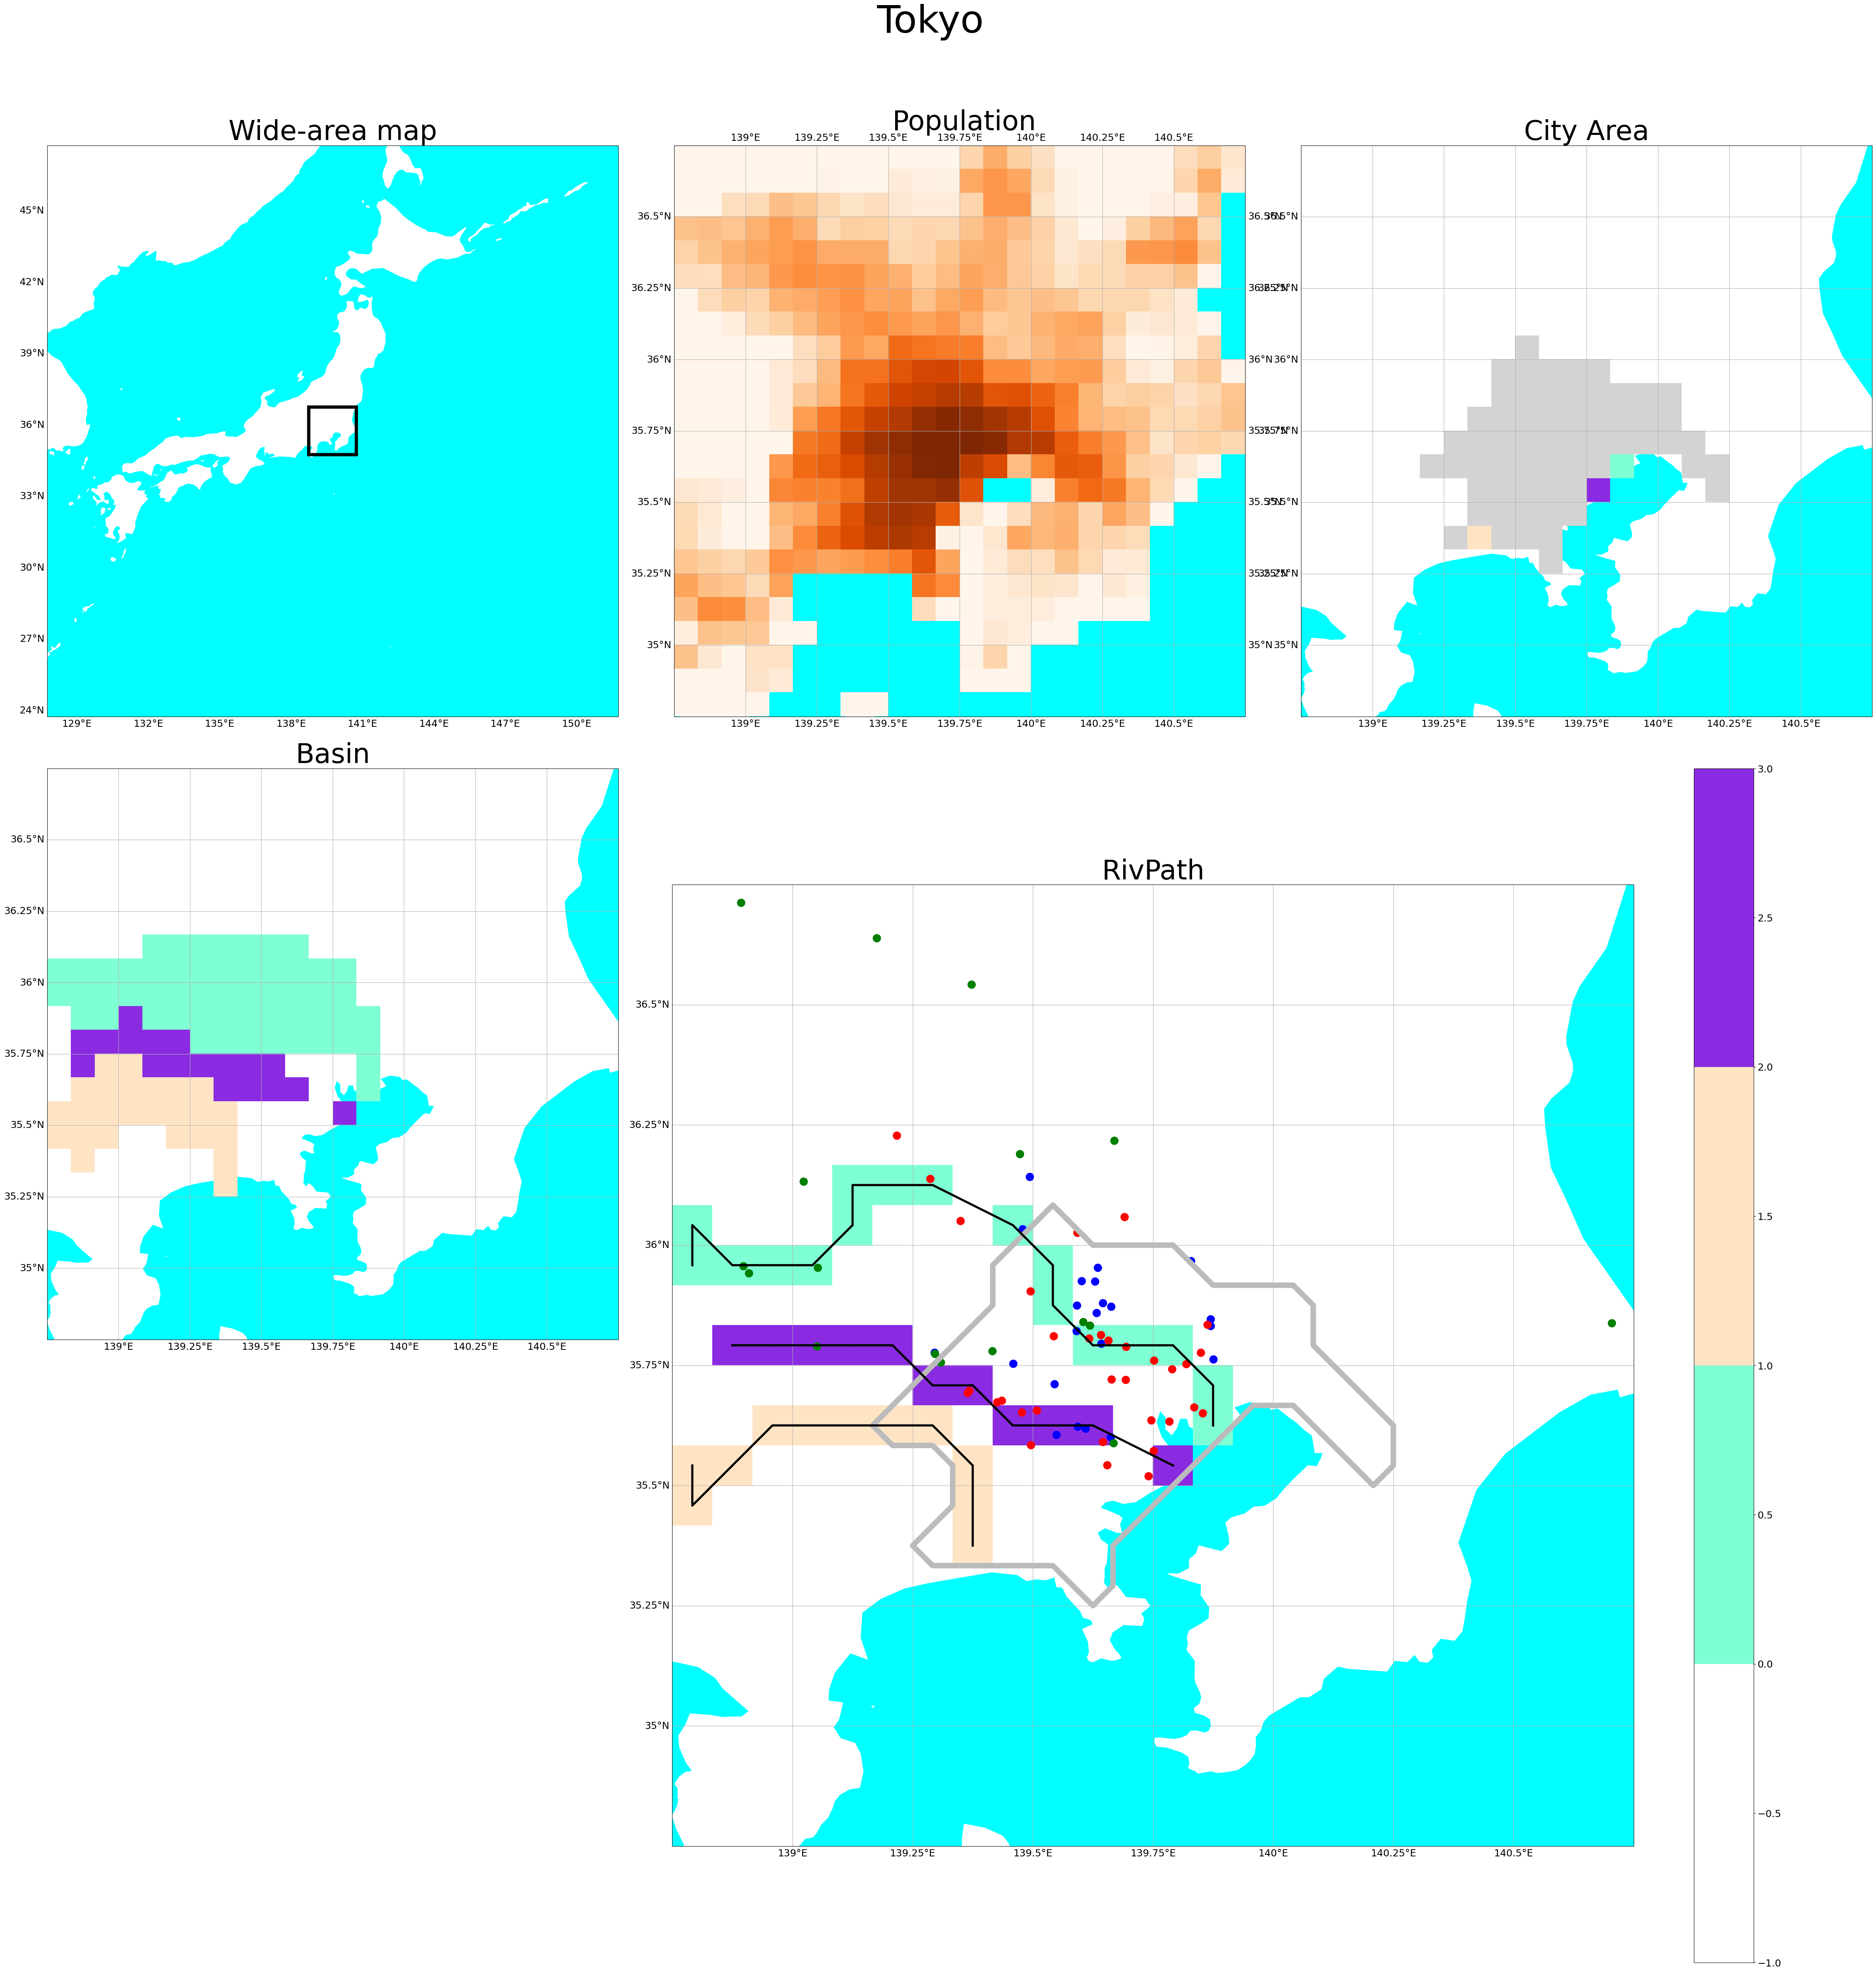

In [63]:
#---------------------------------------------------------------------------------------------------------------
# DRAW
#---------------------------------------------------------------------------------------------------------------

# Create the plot
fig = plt.figure(figsize=(60, 60))
fig.suptitle(f'{city_name}', fontsize=70, y=0.94)

gs = gridspec.GridSpec(6, 6)

# font size
plt.rcParams['font.size'] = 18

#---------------------------------------------------------------------------------------------------------------
# DRAW Wide-area map
#---------------------------------------------------------------------------------------------------------------

rectangle_lon_min, rectangle_lon_max, rectangle_lat_min, rectangle_lat_max = extent

rectangle = Rectangle((rectangle_lon_min, rectangle_lat_min),
                    rectangle_lon_max - rectangle_lon_min,
                    rectangle_lat_max - rectangle_lat_min,
                    facecolor='none',
                    edgecolor='black',
                    linewidth=6,
                    transform=ccrs.PlateCarree(), zorder=2)

# add subplot(gs=6x6, ax9=2x2)
ax9 = fig.add_subplot(gs[0:2, 0:2], projection=projection)
ax9.set_extent(extent2, projection)
gl = ax9.gridlines(draw_labels=True)
gl.xlines = False 
gl.ylines = False
gl.top_labels = False   
gl.right_labels = False 

# Add features and labels   
ax9.add_feature(cfea.OCEAN, color='#00FFFF')
ax9.add_patch(rectangle)
ax9.set_title('Wide-area map', fontsize=50)

#---------------------------------------------------------------------------------------------------------------
#  Basinの図を作図する
#---------------------------------------------------------------------------------------------------------------

def plot_data(fig, gs_position, data, title, Rivnum_masked_array):
    # cmap
    num_colors, index_dict, cmap = make_cmap(Rivnum_masked_array)
    data_masked = np.ma.masked_where(data >= 1e20, data)
    data_filled = data_masked.filled(0)
    indexed_data = np.vectorize(get_index)(data_filled, index_dict)
    
    # draw
    ax = fig.add_subplot(gs_position, projection=projection)
    ax.set_extent(extent, projection)
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False   # Turn off top x-axis labels
    gl.right_labels = False # Turn off right y-axis labels
    ax.add_feature(cfea.OCEAN, color='#00FFFF')
    img = ax.imshow(indexed_data,
                    origin='upper',
                    extent=extent,
                    transform=projection,
                    cmap=cmap,
                    vmin=-1, vmax=num_colors)
    ax.set_title(title, fontsize=50)
    return ax, img

ax18, img18 = plot_data(fig, gs[2:4, 0:2], Rivnum_masked_array, 'Basin', Rivnum_masked_array)

#---------------------------------------------------------------------------------------------------------------
#  City_areaを作図
#---------------------------------------------------------------------------------------------------------------

cmap_gray = colors.ListedColormap(['none', 'lightgray'])
bounds_gray = [0, 0.5, 1]
norm_gray = colors.BoundaryNorm(bounds_gray, cmap_gray.N)

def plot_data_mask(fig, gs_position, data, title, Rivnum_masked_array):
    # cmap
    num_colors, index_dict, cmap = make_cmap(Rivnum_masked_array)
    data_masked = np.ma.masked_where(data >= 1e20, data)
    data_filled = data_masked.filled(0)
    indexed_data = np.vectorize(get_index)(data_filled, index_dict)
    
    # draw
    ax = fig.add_subplot(gs_position, projection=projection)
    ax.set_extent(extent, projection)
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False   # Turn off top x-axis labels
    gl.right_labels = False # Turn off right y-axis labels
    ax.add_feature(cfea.OCEAN, color='#00FFFF')
    img = ax.imshow(indexed_data,
                    origin='upper',
                    extent=extent,
                    transform=projection,
                    cmap=cmap,
                    vmin=-1, vmax=num_colors, zorder=2)
    img_gray = ax.imshow(g_mask_cropped, origin='upper', extent=extent, transform=projection, cmap=cmap_gray, norm=norm_gray, zorder=1)
    ax.set_title(title, fontsize=50)
    return ax, img

ax3, img12 = plot_data_mask(fig, gs[0:2, 4:6], rivnum_max_array_revised, 'City Area', Rivnum_masked_array)

#---------------------------------------------------------------------------------------------------------------
# 人口をプロットする
#---------------------------------------------------------------------------------------------------------------

# Add subplot for population data
ax = fig.add_subplot(gs[0:2, 2:4], projection=projection)
# Set extent
ax.set_extent(extent, crs=projection)
# set gridline
ax.gridlines(draw_labels=True)
# Add features and labels
ax.add_feature(cfea.OCEAN, color='#00FFFF')
# Plot the population data
img = ax.imshow(g_pop_cropped,
                origin='upper',
                extent=extent,
                transform=projection,
                cmap='Oranges',
                norm=colors.LogNorm(vmin=pop_vmin, vmax=pop_vmax)) # Use log color scale
# set colorbar
#fig.colorbar(img, ax=ax, orientation='horizontal')
# Set title
ax.set_title(' Population', fontsize=50)

#---------------------------------------------------------------------------------------------------------------
# RivPathの図を描く
#---------------------------------------------------------------------------------------------------------------

def plot_path_zorder(fig, gs_position, data, title, Rivnum_masked_array, results_dict=None, latmin_gl5=None, latmax_gl5=None, lonmin_gl5=None, lonmax_gl5=None):
    # cmap
    num_colors, index_dict, cmap = make_cmap(Rivnum_masked_array)
    data_masked = np.ma.masked_where(data >= 1e20, data)
    data_filled = data_masked.filled(0)
    indexed_data = np.vectorize(get_index)(data_filled, index_dict)
    
    # draw
    ax = fig.add_subplot(gs_position, projection=projection)
    ax.set_extent(extent, projection)
    ax.scatter(josui['lon'], josui['lat'], color='blue', s=200, transform=projection,zorder=3)
    ax.scatter(gesui['lon'], gesui['lat'], color='red', s=200, transform=projection, zorder=3)
    ax.scatter(seki['lon'], seki['lat'], color='green', s=200, transform=projection, zorder=3)
    light_gray = '#BBBBBB'  # 16進数で薄いグレー
    
    # city maskをコンターで描く
    contour = ax.contour(g_mask_cropped, levels=[0.5], colors=light_gray, linewidths=10, origin='upper', extent=extent, transform=projection, zorder=3)

    # labels
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False   # Turn off top x-axis labels
    gl.right_labels = False # Turn off right y-axis labels

    # ocean
    ax.add_feature(cfea.OCEAN, color='#00FFFF')
    ax.add_feature(cfea.LAKES, color='#00FFFF')
    
    # rivpath
    img = ax.imshow(indexed_data,
                    origin='upper',
                    extent=extent,
                    transform=projection,
                    cmap=cmap,
                    vmin=-1, vmax=num_colors, zorder=2)
    light_gray = '#BBBBBB'  # 16進数で薄いグレー
    ax.set_title(title, fontsize=50)

    # path to paths
    if results_dict is not None and latmin_gl5 is not None and latmax_gl5 is not None and lonmin_gl5 is not None and lonmax_gl5 is not None:
        for key, path in results_dict.items():
            lat_coords, lon_coords = zip(*path)
            lat_coords = [latmax_gl5 - ((lat + (1/(width * 2)))*(1/12)) for lat in lat_coords]
            lon_coords = [(lon + (1/(width * 2)))*(1/12) + lonmin_gl5 for lon in lon_coords]
            ax.plot(lon_coords, lat_coords, marker='o', markersize=2, color='black', linestyle='-', linewidth=4, transform=projection, zorder=5)
    
    # colorbar
    fig.colorbar(img, ax=ax)

    return ax, img

ax22, img22 = plot_path_zorder(fig, gs[2:6, 2:6], riv_path_array, 'RivPath', Rivnum_masked_array, results_dict=results_dict, latmin_gl5=latmin_gl5, latmax_gl5=latmax_gl5, lonmin_gl5=lonmin_gl5, lonmax_gl5=lonmax_gl5)

plt.show()

g_rivnum_cropped


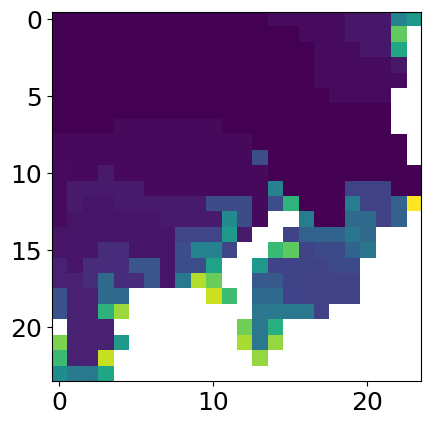

Rivnum_A_array_city


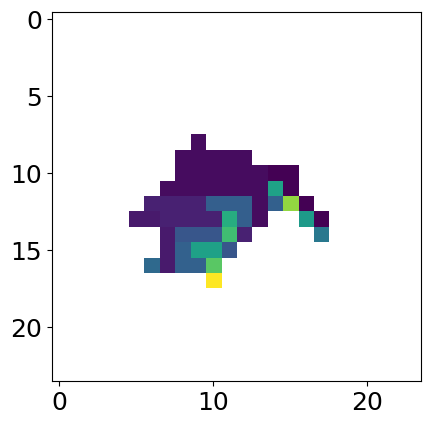

Rivnum_B_array


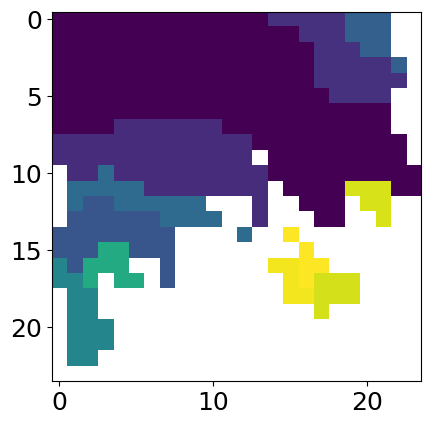

cityarea_with_rivnum_b_array


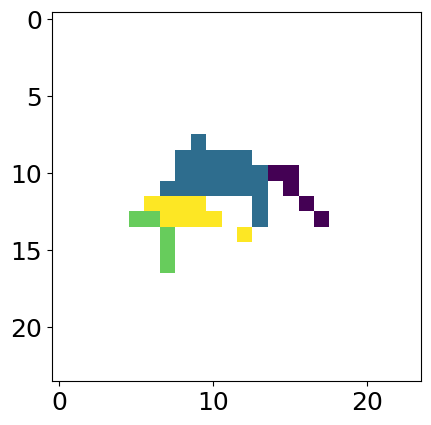

rivnum_max_array


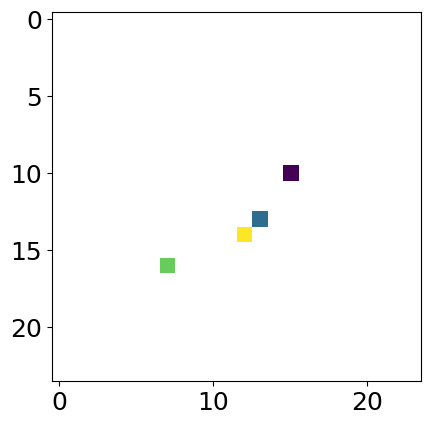

riv_path_array


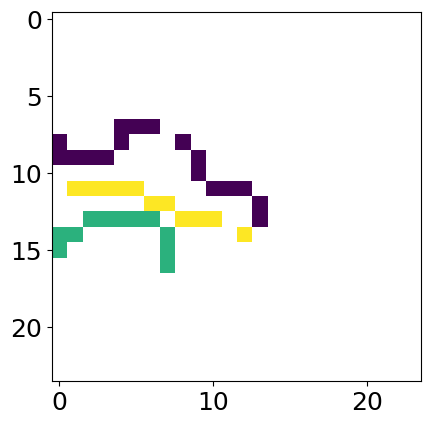

riv_path_city


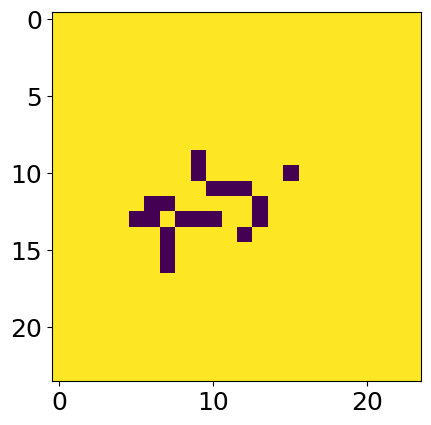

riv_path_array_revised


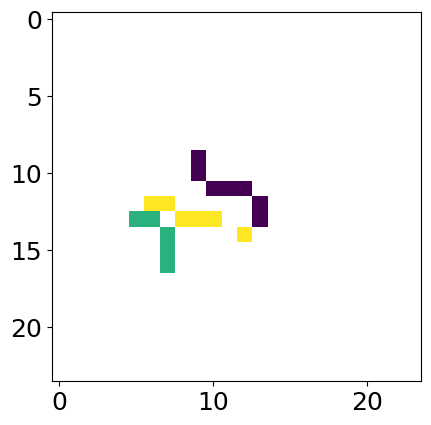

In [39]:
print('g_rivnum_cropped')
plt.imshow(g_rivnum_cropped)
plt.show()
print('Rivnum_A_array_city')
plt.imshow(Rivnum_A_array_city)
plt.show()
print('Rivnum_B_array')
plt.imshow(Rivnum_B_array)
plt.show()
print('cityarea_with_rivnum_b_array')
plt.imshow(cityarea_with_rivnum_b_array)
plt.show()
print('rivnum_max_array')
plt.imshow(rivnum_max_array)
plt.show()
print('riv_path_array')
plt.imshow(riv_path_array)
plt.show()
print('riv_path_city')
plt.imshow(riv_path_city)
plt.show()
print('riv_path_array_revised')
plt.imshow(riv_path_array_revised)
plt.show()

# データ保存

In [99]:
def path_zorder(data, title, Rivnum_masked_array, latmin_gl5=None, latmax_gl5=None, lonmin_gl5=None, lonmax_gl5=None):
    data = np.where(data<1e20, data, -1)
    num_colors, index_dict, cmap = make_cmap(Rivnum_masked_array)
    indexed_data = np.vectorize(get_index)(data, index_dict)
    
    fig = plt.figure()
    ax = plt.subplot(projection=projection)
    ax.coastlines()
    ax.set_extent(extent, projection)
    light_gray = '#BBBBBB'  # 16進数で薄いグレー
    # city maskをコンターで描く
    contour = ax.contour(g_mask_cropped, levels=[0.5], colors=light_gray, linewidths=3, origin='upper', extent=extent, transform=projection, zorder=10)


    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False   # Turn off top x-axis labels
    gl.right_labels = False # Turn off right y-axis labels

    ax.add_feature(cfea.OCEAN, color='#00FFFF')
    ax.add_feature(cfea.LAKES, color='#00FFFF')
    
    img = ax.imshow(indexed_data,
                    origin='upper',
                    extent=extent,
                    transform=projection,
                    cmap=cmap,
                    vmin=-1, vmax=num_colors, zorder=2)
    ax.set_title(title, fontsize=16)
    fig.colorbar(img, ax=ax)
    
#path_zorder(riv_path_array_revised, 'RivPath', Rivnum_masked_array, latmin_gl5=latmin_gl5, latmax_gl5=latmax_gl5, lonmin_gl5=lonmin_gl5, lonmax_gl5=lonmax_gl5)

# purification plant

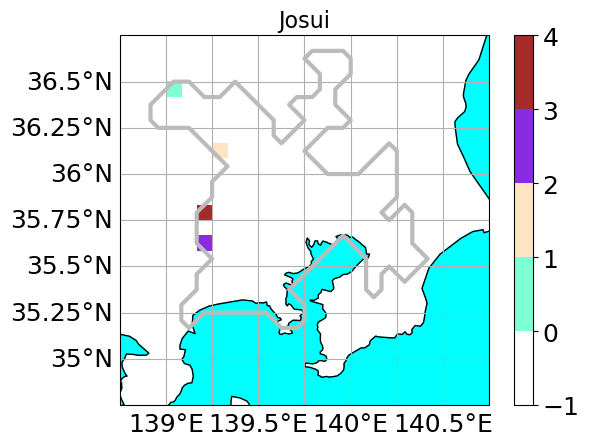

In [108]:
# josui

josui_lst = []

# get uid
unique_values, _ = np.unique(riv_path_array_revised, return_counts=True)
tmp_id_lst = unique_values[:-1]

# city mask
tmp_uid_masked = np.where(g_mask_cropped==1, riv_path_array_revised, np.nan)

# loop uid
for key_num in tmp_id_lst:
    # get river path
    indices = np.argwhere(tmp_uid_masked == key_num)
    
    # get minmum river area
    rivara_values = [g_rivara_cropped[coord[0], coord[1]] for coord in indices]
    tmp_arg = np.argmin(rivara_values)
    josui = indices[tmp_arg]
    
    # add to list
    josui_lst.append(josui)
    
# 浄水場情報を24x24のマスクファイルに保存
josui_array = np.ma.masked_all(rivnum_max_array.shape, dtype='float32')

for matching_position, uid in zip(josui_lst, tmp_id_lst):
    josui_array[matching_position[0], matching_position[1]] = uid
    
path_zorder(josui_array, 'Josui', Rivnum_masked_array, latmin_gl5=latmin_gl5, latmax_gl5=latmax_gl5, lonmin_gl5=lonmin_gl5, lonmax_gl5=lonmax_gl5)

# 保存方法を考える

world elevation data


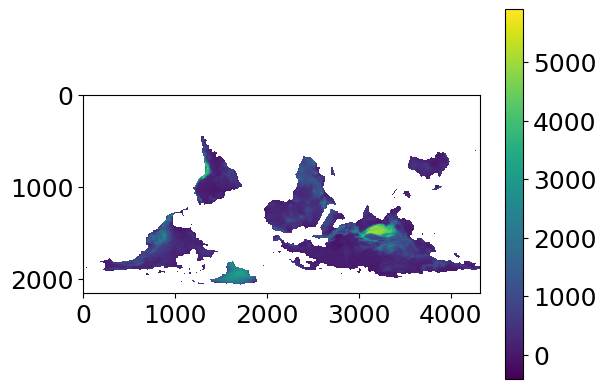

cropped elevation data


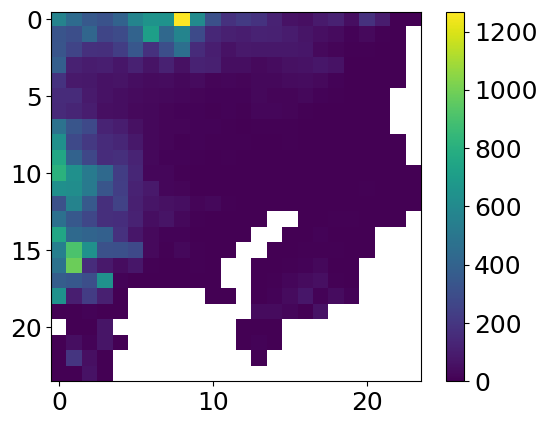

josui data overwritten on elevatoin data


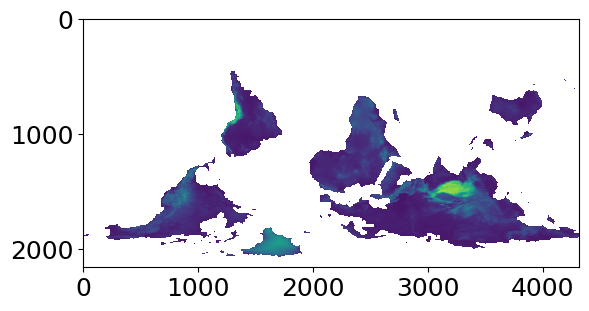

cropped overwritten data


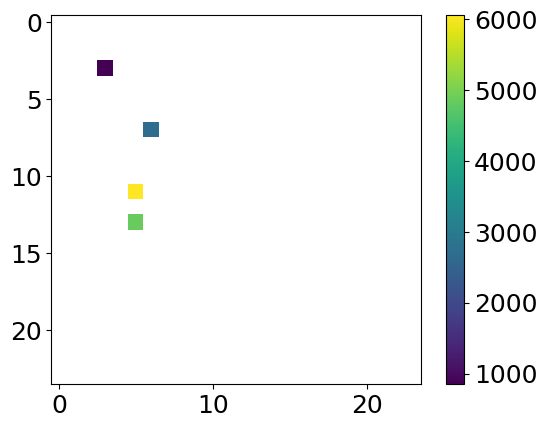

In [117]:
# どうやってひっくり返しているかチェック

# オリジナルはさかさまじゃないよ
g_elv = np.fromfile(elv_path, 'float32').reshape(a, b)
# ひっくり返してからじゃないとlatとlonの区間が合わない
g_elv = np.flipud(g_elv)
g_elv = np.ma.masked_where(g_elv >= 1E20, g_elv)
print('world elevation data')
plt.imshow(g_elv)
plt.colorbar()
plt.show()

g_elv_cropped = g_elv[lat_start:lat_end, lon_start:lon_end]
# croppが終わったら再度ひっくり返す
g_elv_cropped = np.flipud(g_elv_cropped)
print('cropped elevation data')
plt.imshow(g_elv_cropped)
plt.colorbar()
plt.show()

#　cropp区間の値を変換
g_elv[lat_start:lat_end, lon_start:lon_end] = np.flipud(josui_array)
print('josui data overwritten on elevatoin data')
plt.imshow(g_elv)
plt.show()

# 再度クロップ
g_elv_cropped = g_elv[lat_start:lat_end, lon_start:lon_end]
# croppが終わったら再度ひっくり返す
g_elv_cropped = np.flipud(g_elv_cropped)
print('cropped overwritten data')
plt.imshow(g_elv_cropped)
plt.colorbar()
plt.show()

# 保存するときは世界地図をひっくり返して，正しい向きにしておく
g_elv = np.flipud(g_elv)

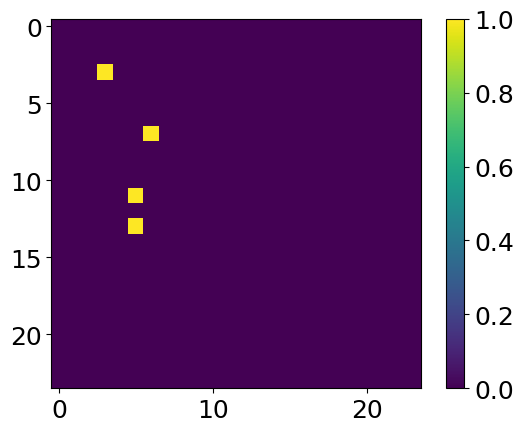

In [114]:
# croppするときは必ずひっくり返す
# 保存・描写するときにもとに戻す
### 実際に浄水場位置を保存する

# 保存用ファイル作成
josui_for_save = np.ma.masked_all(g_elv.shape, dtype='float32')

#　cropp区間の値を変換(世界地図はひっくり返っている)
josui_for_save[lat_start:lat_end, lon_start:lon_end] = np.flipud(josui_array)

# 浄水場を1, それ以外を0とするバイナリーファイルに変換
josui_for_save = np.ma.filled(josui_for_save, fill_value=0)
josui_for_save = np.where(josui_for_save > 0, 1, josui_for_save)

# cropが正しく変換されているか確認
josui_cropped = josui_for_save[lat_start:lat_end, lon_start:lon_end]
# croppが終わったらひっくり返す(世界地図上向き)
josui_cropped = np.flipud(josui_cropped)
plt.imshow(josui_cropped)
plt.colorbar()
plt.show()

# 保存するときは世界地図をひっくり返して，正しい向きにしておく
# city purification plant
num = idx+1 # city ID
save_path = f'/home/kajiyama/H08/H08_20230612/map/dat/cty_prf_/city_{num:08d}.gl5'
josui_for_save = np.flipud(josui_for_save)
#josui_for_save.astype(np.float32).tofile(save_path)
#print(f"{save_path} saved")

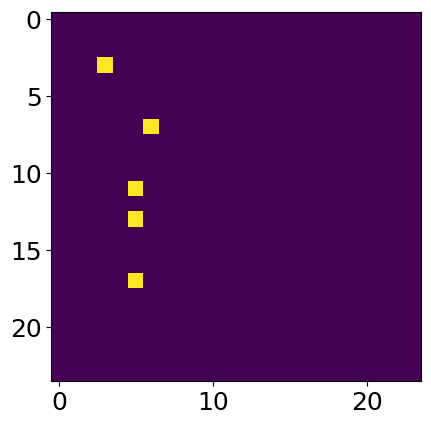

In [115]:
# load file
tmp = np.fromfile(save_path, 'float32').reshape(a, b)
tmp = np.flipud(tmp)
tmp_crop = tmp[lat_start:lat_end, lon_start:lon_end]
tmp_crop = np.flipud(tmp_crop)
plt.imshow(tmp_crop)

# sewage plant

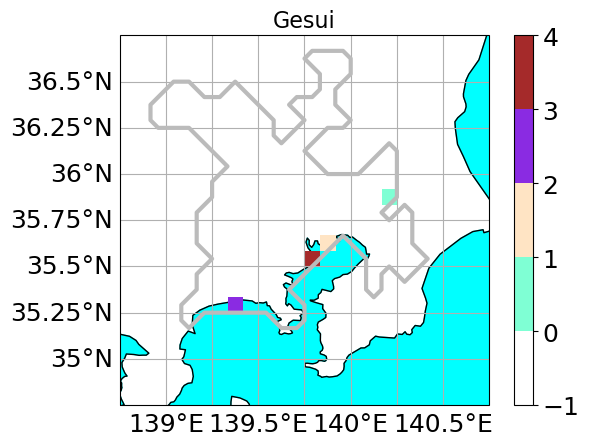

In [118]:
# gesui

#---------------------------------------------------------------------------------------------------------------
#  Load upper river catchment area
#---------------------------------------------------------------------------------------------------------------

rivara_path = f"{root_dir}/map/out/riv_ara_/rivara.CAMA.gl5"
g_rivara = np.fromfile(rivara_path, 'float32').reshape(a, b)
g_rivara = np.flipud(g_rivara)
g_rivara = np.ma.masked_where(g_rivara >= 1E20, g_rivara)
g_rivara_cropped = g_rivara[lat_start:lat_end, lon_start:lon_end]
g_rivara_cropped = np.flipud(g_rivara_cropped)
g_rivara_cropped = np.ma.masked_where(~np.isfinite(g_rivara_cropped) | (g_rivara_cropped == 0), g_rivara_cropped)
    
#---------------------------------------------------------------------------------------------------------------
#  gesui file
#---------------------------------------------------------------------------------------------------------------

# 探索する対象ファイルを作る
gesui_array = np.ma.masked_all(rivnum_max_array.shape, dtype='float32')

# get uid
unique_values, _ = np.unique(riv_path_array_revised, return_counts=True)
tmp_id_lst = unique_values[:-1]

# rivnumが同じものの最下流を探す
for rivnum_id in tmp_id_lst:
    # 同じrivnumの位置を取得
    matching_positions = np.where(cityarea_with_rivnum_b_array == rivnum_id) 
    # これらの位置におけるrivaraの最大値の位置を取得
    max_rivara_position = np.argmax(g_rivara_cropped[matching_positions])       
    # 最大のrivaraの位置(河口グリッドに該当)に対応するrivnumを新しい配列に保存
    gesui_array[matching_positions[0][max_rivara_position], matching_positions[1][max_rivara_position]] = rivnum_id
    
path_zorder(gesui_array, 'Gesui', Rivnum_masked_array, latmin_gl5=latmin_gl5, latmax_gl5=latmax_gl5, lonmin_gl5=lonmin_gl5, lonmax_gl5=lonmax_gl5)

elevation data


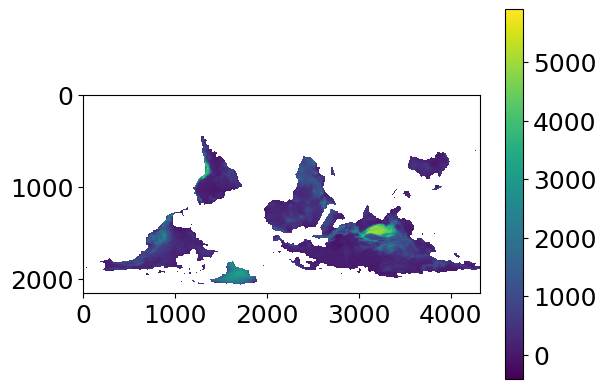

cropped elevation data


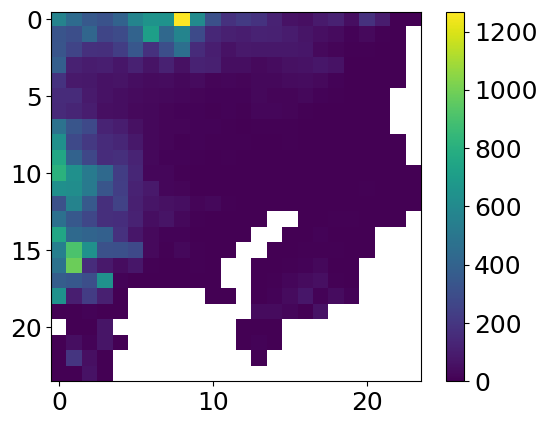

gesui data overwritten on elevation data


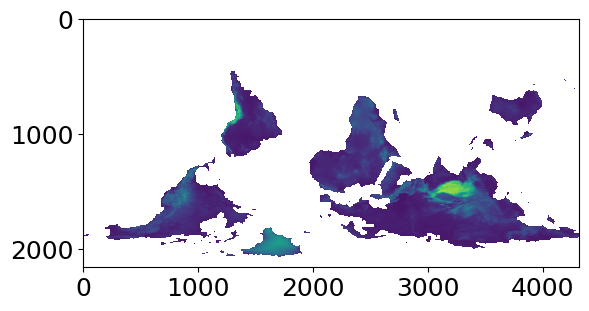

cropped overwritten data


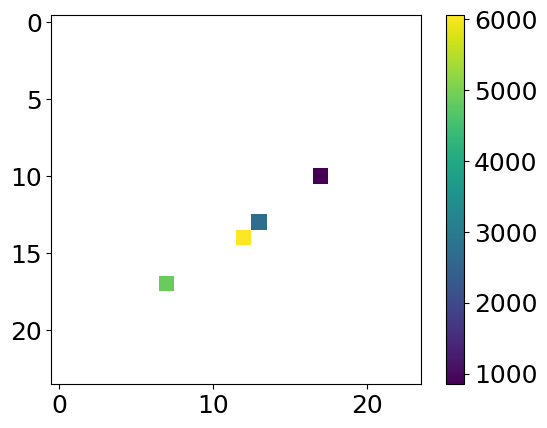

In [119]:
# どうやってひっくり返しているかチェック

# オリジナルはさかさまじゃないよ
g_elv = np.fromfile(elv_path, 'float32').reshape(a, b)
# ひっくり返してからじゃないとlatとlonの区間が合わない
g_elv = np.flipud(g_elv)
g_elv = np.ma.masked_where(g_elv >= 1E20, g_elv)
print('elevation data')
plt.imshow(g_elv)
plt.colorbar()
plt.show()

g_elv_cropped = g_elv[lat_start:lat_end, lon_start:lon_end]
# croppが終わったら再度ひっくり返す
g_elv_cropped = np.flipud(g_elv_cropped)
print('cropped elevation data')
plt.imshow(g_elv_cropped)
plt.colorbar()
plt.show()

#　cropp区間の値を変換
g_elv[lat_start:lat_end, lon_start:lon_end] = np.flipud(gesui_array)
print('gesui data overwritten on elevation data')
plt.imshow(g_elv)
plt.show()

# 再度クロップ
g_elv_cropped = g_elv[lat_start:lat_end, lon_start:lon_end]
# croppが終わったら再度ひっくり返す
g_elv_cropped = np.flipud(g_elv_cropped)
print('cropped overwritten data')
plt.imshow(g_elv_cropped)
plt.colorbar()
plt.show()

# 保存するときは世界地図をひっくり返して，正しい向きにしておく
g_elv = np.flipud(g_elv)
#np.save

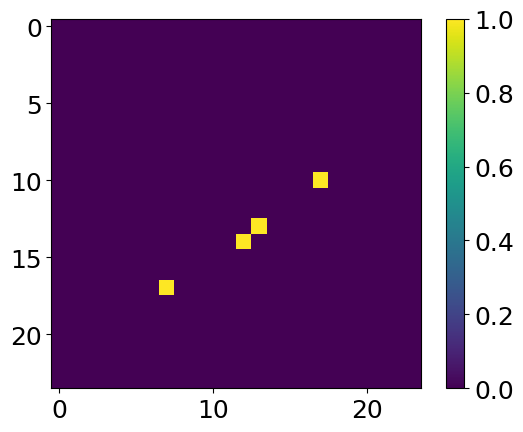

In [120]:
# croppするときは必ずひっくり返す
# 保存・描写するときにもとに戻す
### 実際に浄水場位置を保存する

# 保存用ファイル作成
gesui_for_save = np.ma.masked_all(g_elv.shape, dtype='float32')

#　cropp区間の値を変換(世界地図はひっくり返っている)
gesui_for_save[lat_start:lat_end, lon_start:lon_end] = np.flipud(gesui_array)

# 浄水場を1, それ以外を0とするバイナリーファイルに変換
gesui_for_save = np.ma.filled(gesui_for_save, fill_value=0)
gesui_for_save = np.where(gesui_for_save > 0, 1, gesui_for_save)

# cropが正しく変換されているか確認
gesui_cropped = gesui_for_save[lat_start:lat_end, lon_start:lon_end]
# croppが終わったらひっくり返す(世界地図上向き)
gesui_cropped = np.flipud(gesui_cropped)
plt.imshow(gesui_cropped)
plt.colorbar()
plt.show()

# 保存するときは世界地図をひっくり返して，正しい向きにしておく
# city purification plant
num = idx+1 # city ID
save_path = f'/home/kajiyama/H08/H08_20230612/map/dat/cty_swg_/city_{num:08d}.gl5'
gesui_for_save = np.flipud(gesui_for_save)
#gesui_for_save.astype(np.float32).tofile(save_path)
#print(f"{save_path} saved")

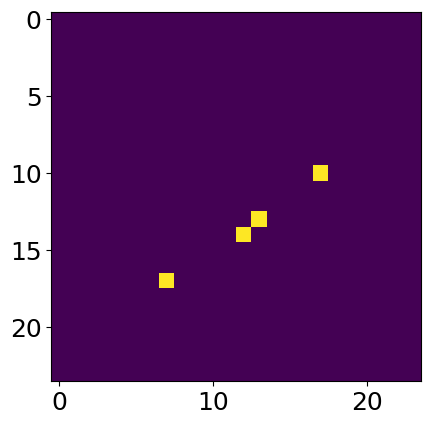

In [122]:
# load file
tmp = np.fromfile(save_path, 'float32').reshape(a, b)
tmp = np.flipud(tmp)
tmp_crop = tmp[lat_start:lat_end, lon_start:lon_end]
tmp_crop = np.flipud(tmp_crop)
plt.imshow(tmp_crop)